In [143]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [193]:
n_total = 10000
ards_p = 0.15

n_ards = int(n_total*ards_p)
n_non_ards = int(n_total*(1-ards_p))

# vars= HR, RR, SpO2, PF, creatinine, lactate
mean_ards = [ 80,   30,  90,  75,    3,     5 ]

cov_ards = [[  1,  0.1, 0.2, 0.2, 0.1, 0.1],
            [0.1,    1, 0.2, 0.8, 0.1, 0.1],
            [0.2,  0.2,   1, 0.2, 0.1, 0.1],
            [0.2,  0.8, 0.2,   1, 0.2, 0.1],
            [0.1, 0.1, 0.1, 0.2,   1, 0.9],
            [0.1,  0.1, 0.1, 0.1, 0.9,   1]]

mean_non_ards = [80 , 24,  97,  346,   2,  2]
cov_non_ards = cov_ards

ards =     np.random.multivariate_normal(mean_ards, cov_ards, n_ards)
scaler = StandardScaler().fit(ards)
ards = scaler.transform(ards)
ards = ards + np.random.normal(0,1)

non_ards = np.random.multivariate_normal(mean_non_ards, cov_non_ards, n_non_ards)
scaler = StandardScaler().fit(non_ards)
non_ards = scaler.transform(non_ards)
non_ards = non_ards + np.random.normal(0,1)

In [199]:
# simulation
logit_auroc =[]
logit_upper = []
logit_lower = []


samplesize = range(100,2000, 100)
for i in samplesize:
    temp_logit_auroc = []
    temp_upper = []
    temp_lower = []
    for j in range(10):
        # sampling
        n_study_ards = int(i*ards_p)
        n_study_non_ards = int(i*(1-ards_p))
        # ards
        idx = np.random.choice(n_ards, n_study_ards, replace= False)
        study_ards = ards[idx,:]
        # non ards
        idx = np.random.choice(n_non_ards, n_study_non_ards, replace= False)
        study_non_ards = non_ards[idx,:]
        # study y 
        study_y = []
        for i in range(n_study_ards):
            study_y.append(1)
        for i in range(n_study_non_ards):
            study_y.append(0)
        # study pop
        study_x = np.concatenate((study_ards, study_non_ards)) 
        # traintest
        x_train, x_test, y_train, y_test = train_test_split(study_x, study_y, test_size = 0.3, stratify =study_y)
        # logistic regression
        logit = LogisticRegression().fit(x_train, y_train)
        # test
        y_pred = logit.predict(x_test)
        y_proba = logit.predict_proba(x_test)[:,1]
        auroc = roc_auc_score(y_test, y_proba)
        temp_logit_auroc.append(auroc)
        se = np.sqrt(auroc*(1-auroc)/len(y_test))
        moe = 1.96*se
        upper = auroc + moe
        lower = auroc - moe
        temp_lower.append(lower)
        temp_upper.append(upper)
    logit_auroc.append(np.mean(temp_logit_auroc))
    logit_upper.append(np.mean(temp_upper))
    logit_lower.append(np.mean(temp_lower))
    
res = pl.DataFrame(
    {
        "n": samplesize,
        "LogAUROC" : logit_auroc,
        "upper": logit_upper,
        "lower": logit_lower
    }
)
res

n,LogAUROC,upper,lower
i64,f64,f64,f64
100,0.982476,1.003691,0.961261
200,0.958427,1.017316,0.899537
300,0.955447,1.013717,0.897178
400,0.949884,1.006252,0.893517
500,0.923971,0.985512,0.86243
600,0.953096,0.996437,0.909756
700,0.950442,0.993191,0.907693
800,0.948706,0.989242,0.908171
900,0.965978,0.997709,0.934247


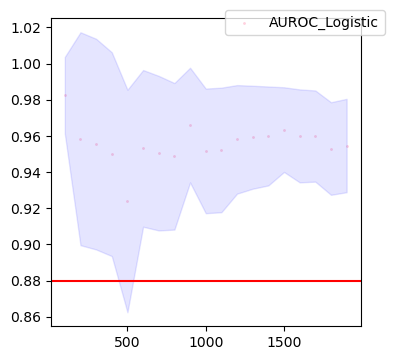

In [200]:
fig = plt.figure(figsize = (4,4))
color = ["#c20078","#0504aa","#75bbfd","#ffd1df","#c79fef","#014d4e"]
plt.scatter(res[:,0],res[:,1], s=1, c= color[3], label = "AUROC_Logistic")
plt.fill_between(res[:,0], res[:,3], res[:,2], color='b', alpha=.1)
plt.axhline(y = 0.88, color = 'r', linestyle = '-')
plt.legend(bbox_to_anchor=(1.1, 1.05))